![logo](img/LogoLine_horizon_C3S.png)

<br>

# Tutorial on calculating a climate index for Summer Days

#### About

This tutorial will demonstrate how to calculate a climate index using a specific climate indices package. The example provided is of the Summer Days index, but similar principles can be applied to many other types of single or multi-variable indices available in the icclim package.

The data is provided by Copernicus Climate Change Service (C3S) and includes daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations (E-OBS) of maximum temperature, minimum temperature, and precipitation.

The tutorial will first show how to download the necessary data from the C3S Climate Data Store (CDS). It will then describe how to calculate the Summer Days Index, and finally plot a map of the Summer Days climatology over Europe.

The steps shown in this tutorial can be applied to other climate datasets with the proper variable to calculate specific climate indices. For the current index, Summer Days, the Maximum Daily Temperature variable is needed.

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|NBViewer|
|:-:|
[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.org/github/cerfacs-globc/copernicus-training/blob/master/C3S_climate-indices_icclim.ipynb)|
|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need.
You also need at least python version 3.8 for this notebook to work because of some requirements from some packages. 

You will need to install [icclim](https://github.com/cerfacs-globc/icclim) (`%pip install icclim`) for calculating the climate indices, and the CDS API (`%pip install cdsapi`) for downloading data programatically from the CDS. You will also need to install matplotlib (`%pip install matplotlib`) and cartopy (`%conda install cartopy`) to enable plotting of the results. The % character is to ensure installation occurs in your environment. The installation of cartopy requires a conda environment, if not already installed.

## Search, download and view data

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

#### Install CDS API

To install the CDS API, run the following command if not already installed in your environment.

In [1]:
%pip install cdsapi

Note: you may need to restart the kernel to use updated packages.


#### Install icclim

To install icclim, run the following command if not already installed in your environment.

In [2]:
%pip install icclim

Note: you may need to restart the kernel to use updated packages.


#### Install matplotlib and cartopy

To install matplotlib and cartopy to enable plotting, run the following command if not already installed in your environment.
A conda environment is expected as cartopy cannot be correctly installed with pip.

In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
%conda install -y cartopy

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


#### Import libraries

We will be working with data in NetCDF format and calculating climate indices. We will use the icclim package and its dependencies for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [5]:
# CDS API
import cdsapi

# icclim package for calculating climate indices
import icclim

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# To add specific units spelling
from xclim.core.units import units

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

# To unzip dataset files from the CDS
from zipfile import ZipFile

#### Enter your CDS API key

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.

In [6]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '#########'


Here we specify a data directory in which we will download our data and all output files that we will generate:

In [7]:
DATADIR = './'

#### Search for climate data to calculate summer days

The summer days index we will calculate takes one parameter as input, it is the 2m near-surface daily maximum air temperature. Data for this parameter is available as part of the E-OBS daily gridded meteorological data for Europe from 1950 to present, but we will select a shorter period so that the download is faster: we will select the period from 2011 to 2021. We will search for this data on the CDS website: http://cds.climate.copernicus.eu. The specific dataset we will use is the `E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations`. 

<img src='./img/CDS_welcome.png' align='left' width='45%'></img> <img src='./img/EOBS_daily.png' align='right' width='45%'></img> 

Having selected the dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Product type: `Ensemble mean`
- Variable: `Maximum temperature`
- Grid resolution: `0.1deg`
- Period: `2011_2021`
- Version: `25.0e` (Latest version)
- Format: `Zip file (.zip)`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cells below). You will do this once for maximum temperature.

#### Download data

... having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the **terms and conditions** of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **"Show API request"** option.

In [8]:
c = cdsapi.Client(url=URL, key=KEY)

# For the full period, use period: 'full_period' but it takes a long time to download data
# To download last decade use 'period': '2011_2021',

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'format': 'zip',
        'product_type': 'ensemble_mean',
        'variable': 'maximum_temperature',
        'grid_resolution': '0.1deg',
        'period': '2011_2021',
        'version': '25.0e',
    },
    'eobs_tasmax.zip')

2022-05-05 15:57:21,712 Welcome to the CDS
2022-05-05 15:57:21,712 Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-europe
2022-05-05 15:57:21,817 Request is queued
2022-05-05 15:57:22,876 Request is running
2022-05-05 16:07:40,823 Request is completed
2022-05-05 16:07:40,824 Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data3/dataset-insitu-gridded-observations-europe-f1a62437-bb5f-4e4d-bec9-ad9f10aa45bc.zip to eobs_tasmax.zip (5.3G)
2022-05-05 16:12:26,860 Download rate 19.1M/s                                                                                                


Result(content_length=5736574305,content_type=application/zip,location=https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data3/dataset-insitu-gridded-observations-europe-f1a62437-bb5f-4e4d-bec9-ad9f10aa45bc.zip)

#### Inspect Data

We have requested the data in a zip archive. This zip archive contains a file in the NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the underlying Xarray library that is used by the software to calculate the climate index. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will uncompress the archive and retrieve the filename(s). The archive could contain several files, but since we requested only one time period, we have a list of one file.

In [9]:
# Create a ZipFile Object and load eobs_tasmax.zip in it
with ZipFile('eobs_tasmax.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# List the NetCDF filenames of the dataset
print(listOfFileNames)

['tx_ens_mean_0.1deg_reg_v25.0e.nc']


## Calculate Summer Days index using icclim

Let's calculate using icclim Summer Days (SU) function for the months of June July and August (JJA) using the [icclim](https://icclim.readthedocs.io/en/stable/) software. We retrieve the calculated values in an Xarray dataset, but alternatively we could also write the values automatically in an output NetCDF file using the keyword out_file when calling the icclim function.

In [10]:
# Add specific unit spelling
units.define("@alias degC = C = deg_C = Celsius")

# Add out_file='out_icclim.nc' to also output data into a NetCDF file
summer_days = icclim.su(in_files=listOfFileNames, slice_mode='JJA')
#summer_days = icclim.index(in_files=listOfFileNames, index_name="SU", slice_mode='JJA')

2022-05-05 16:16:18,635 --- icclim 5.2.1
2022-05-05 16:16:18,636 --- BEGIN EXECUTION
2022-05-05 16:16:18,636 Processing: 0%
/Users/page/miniconda3/envs/icclimv5/lib/python3.8/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
2022-05-05 16:16:18,723 Calculating climate index: SU
/Users/page/miniconda3/envs/icclimv5/lib/python3.8/site-packages/xclim/core/indicator.py:1221: UserWarning: Unable to infer the frequency of the time series. To mute this, set xclim's option data_validation='log'.
  datachecks.check_freq(da, self.src_freq, strict=True)
/Users/page/miniconda3/envs/icclimv5/lib/python3.8

Before we plot the results, we can query our newly created Xarray dataset ...

In [11]:
summer_days

,Array,Chunk
Bytes,180.08 MiB,88.02 kiB
Shape,"(72, 465, 705)","(1, 86, 131)"
Count,19802 Tasks,2592 Chunks
Type,float64,numpy.ndarray


We see that summer_days (dataset for the Summer Days index) has one variable called "SU". If you view the documentation of [icclim](https://icclim.readthedocs.io/en/stable/explanation/climate_indices.html) you will see that this is the Number of Summer Days (Daily Maximum Temperature > 25C) valid for a grid cell at the height of 2m above the surface. The units are degrees Celsius.

While an Xarray dataset may contain multiple variables, an Xarray data array holds a single multi-dimensional variable and its coordinates.

Now let's plot the average summer days for this time over Europe, and we take the same European subset as that used for the [C3S Climate Bulletins](https://climate.copernicus.eu/climate-bulletins).

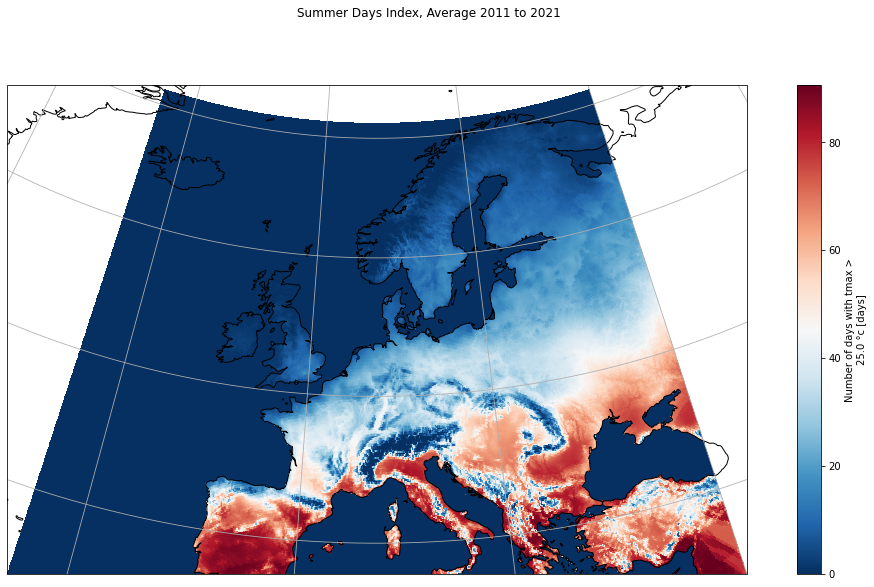

In [12]:
# Set spatial extent and centre
central_lat = 53.0
central_lon = 7.5
extent = [-25, 40, 34, 72]  # Western Europe

# Calculate time average
summer_days_avg = summer_days["SU"].mean(dim='time', keep_attrs=True)

# Select European subset
summer_days_sub = summer_days_avg.where((summer_days_avg.latitude < 72) & 
                              (summer_days_avg.latitude > 34) & 
                              (summer_days_avg.longitude < 40) & 
                              (summer_days_avg.longitude > -25), drop=True)

# Set plot projection
map_proj = ccrs.AlbersEqualArea(central_longitude=central_lon,
                                central_latitude=central_lat)

# Define plot
f, ax = plt.subplots(figsize=(18, 9),
                     subplot_kw={'projection': map_proj})

# Plot data with proper colormap scale range
#levels = np.arange(0, 1.0, 0.1)
p = summer_days_sub.plot(cmap='RdBu_r',
                transform=ccrs.PlateCarree())

# Plot information
plt.suptitle("Summer Days Index, Average over entire time period", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig(f'{DATADIR}E-OBS_summer_days_index.png')

We can notice that we have the expected spatial gradient with fewer Summer Days in the north and in the mountains. Since the dataset only has data over the continent, the values over the sea are not to take into account.

<hr>